In [7]:
import numpy as np
import openpyxl
from pandas import DataFrame, read_csv, merge
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
loan_df = read_csv("loan.csv")

loan_df["loan_type"] = [val.lower().strip() if isinstance(val, str) else val 
                        for val in loan_df.loan_type ]

In [9]:
loan_df.columns

Index(['id', 'loan_id', 'loan_type', 'amt_requested', 'loan_amt_usd',
       'loan_amt_ld', 'rate', 'interest ld', 'interest usd', 'duration_month',
       'status', 'take_out_dt', 'cash available usd', 'cash available ld',
       'total investment'],
      dtype='object')

In [10]:
loan_df = loan_df.replace(['person'], 'personal')

In [11]:
# get approved loans

appr = loan_df.loc[loan_df.status == 'approved']
appr.index = range(appr.shape[0])

# get Liberian dollar loans

ld_loan = DataFrame( appr.loc[~appr.loan_amt_ld.isnull()] )
ld_loan["loan_amt_ld"] = [float(num) for num in ld_loan["loan_amt_ld"]]
ld_loan.index = range(ld_loan.shape[0])

# get US dollar loans

usd_loan = DataFrame( appr.loc[~appr.loan_amt_usd.isnull()] )
usd_loan["loan_amt_usd"] = [float(num) for num in usd_loan["loan_amt_usd"]]
usd_loan.index = range(usd_loan.shape[0])

In [12]:
# get stats by loan_type

ld_ln_grp = ld_loan.groupby("loan_type", as_index=False).agg({"loan_id": "count", 
                                                              "loan_amt_ld": "sum"})
ld_ln_grp = ld_ln_grp.rename(columns = {"loan_id": "nbr_ld_loans"})

usd_ln_grp = usd_loan.groupby("loan_type", as_index=False).agg({"loan_id": "count", 
                                                               "loan_amt_usd": "sum"})
usd_ln_grp = usd_ln_grp.rename(columns = {"loan_id": "nbr_usd_loans"})

# merge groups

merged_ln_grps = merge(ld_ln_grp, usd_ln_grp, on="loan_type", how="outer")

# add total row

row = merged_ln_grps.values.sum(axis=0)
row[0] = "total"

merged_ln_grps.loc[-1] = row
merged_ln_grps.index = range(merged_ln_grps.shape[0])

In [13]:
merged_ln_grps

,loan_type,nbr_ld_loans,loan_amt_ld,nbr_usd_loans,loan_amt_usd
0,business,19,238300.0,11,2300.0
1,personal,4,27250.0,17,1925.0
2,total,23,265550.0,28,4225.0


In [16]:
x_rate = 115.0

merged_ln_grps['total_usd_plus_ld'] = merged_ln_grps.loan_amt_ld / x_rate + merged_ln_grps.loan_amt_usd

In [17]:
merged_ln_grps

,loan_type,nbr_ld_loans,loan_amt_ld,nbr_usd_loans,loan_amt_usd,total_usd_plus_ld
0,business,19,238300.0,11,2300.0,4372.173913
1,personal,4,27250.0,17,1925.0,2161.956522
2,total,23,265550.0,28,4225.0,6534.130435


In [18]:
merged_ln_grps.to_csv('disbursed.csv', header=True, index=None)

In [19]:
def plot_bars(x_vals, y_vals, fig_size=(5, 4), x_label=None, y_label=None, title=None, pct=None,
             rotation=0, pf=None):
    ld_norm = 1e6
    usd_norm = 1e3
    if pct:
        x_vals = x_vals[:-1]
        total = y_vals[-1]
        y_vals = y_vals[:-1]
        y_vals = 100 * (y_vals / total)
        y_label = 'PCT OF PORTFOLIO'
    if title is None:
        if pf and pf.lower() == 'ld':
            title = 'LD PORTFOLIO'
            if pct is None:
                y_vals = y_vals / ld_norm
                y_label = 'LD ( MM )'
        elif pf and pf.lower() == 'usd':
            title = 'USD PORTFOLIO'
            if pct is None:
                y_vals = y_vals / usd_norm
                y_label = 'USD ( KK )'
        elif pf and pf.lower() == 'total':
            title = 'Total PORTFOLIO (USD)'
            if pct is None:
                y_vals = y_vals / usd_norm
                y_label = 'USD ( KK )'
    x_pos = np.arange(1, len(x_vals) + 1)
    plt.figure(figsize=fig_size)
    plt.bar(left=x_pos, height=y_vals, color='lightblue', width=0.8)
    locs, labels = plt.xticks(x_pos, x_vals)
    plt.setp(labels, rotation=rotation) 
    pct_vals = 100 * (y_vals[:2] / y_vals[-1])
    for xyz in zip(x_pos[:2], y_vals[:2], pct_vals): 
        plt.annotate('%.2f%s' % (xyz[-1], '%'), xy=[xyz[0] -0.2, xyz[1]], textcoords='data', fontsize='large')
    
    if pct:
        plt.yticks(np.arange(0, 100, 10))
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if title:
        plt.title(title)
    plt.tight_layout()

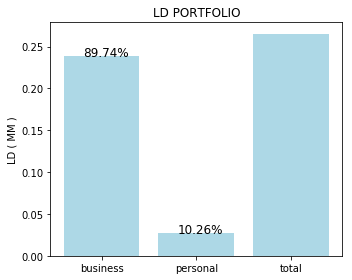

In [20]:
ld_y_vals = merged_ln_grps.loan_amt_ld.values
ld_x_vals = merged_ln_grps.loan_type.values
plot_bars(x_vals=ld_x_vals, y_vals=ld_y_vals, pf='LD', pct=None)
ifile = 'ttl_ld_pf_amt.png'
plt.savefig(ifile, dpi=300, bbox_inches='tight')
plt.show()

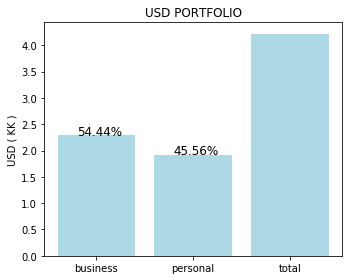

In [21]:
usd_y_vals = merged_ln_grps.loan_amt_usd.values
usd_x_vals = merged_ln_grps.loan_type.values
plot_bars(x_vals=usd_x_vals, y_vals=usd_y_vals, pf='USD', pct=None)
ifile = 'ttl_usd_pf_amt.png'
plt.savefig(ifile, dpi=300, bbox_inches='tight')
plt.show()

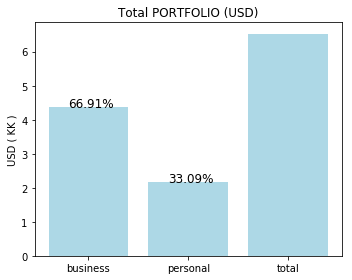

In [22]:
ttl_y_vals = merged_ln_grps.total_usd_plus_ld.values
ttl_x_vals = merged_ln_grps.loan_type.values
plot_bars(x_vals=ttl_x_vals, y_vals=ttl_y_vals, pf='total', pct=None)
ifile = 'ttl_pf_amt.png'
plt.savefig(ifile, dpi=300, bbox_inches='tight')
plt.show()

In [23]:
merged_ln_grps.to_csv("loan_summary.csv", header=True, index=False)

In [24]:
merged_ln_grps.to_excel("loan_summary.xlsx", index=False)

## TO DO: Email component

In [9]:
import smtplib
# import email.mime as mime

from email.mime.message import MIMEMessage, message
# Import the email modules we'll need
from email.mime.text import MIMEText


In [10]:
# Import smtplib for the actual sending function
import smtplib

# Import the email modules we'll need
from email.message import EmailMessage

# Open the plain text file whose name is in textfile for reading.
with open(textfile) as fp:
    # Create a text/plain message
    msg = EmailMessage()
    msg.set_content(fp.read())

me == sannahziama@gmail.com
you == spziama@gmail.com
msg['Subject'] = 'The contents of %s' % textfile
msg['From'] = me
msg['To'] = you

# Send the message via our own SMTP server.
s = smtplib.SMTP('localhost')
s.send_message(msg)
s.quit()

NameError: name 'textfile' is not defined

In [92]:
#!/usr/bin/env python
# encoding: utf-8
"""
Mailer.py
Created by Robert Dempsey on 11/07/14.
Copyright (c) 2014 Robert Dempsey. All rights reserved.
"""

import sys
import os
import smtplib
from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

COMMASPACE = ', '

class Mailer:
    def __init__(self, **kwargs):
        self.properties = kwargs

    # Subject
    @property
    def subject(self):
        return self.properties.get('subject', 'None')

    @subject.setter
    def subject(self, s):
        self.properties['subject'] = s

    @subject.deleter
    def subject(self):
        del self.properties['subject']

    # Recipients
    @property
    def recipients(self):
        return self.properties.get('recipients', 'None')

    @recipients.setter
    def recipients(self, r):
        self.properties['recipients'] = r

    @recipients.deleter
    def recipients(self):
        del self.properties['recipients']

    # Send From
    @property
    def send_from(self):
        return self.properties.get('send_from', 'None')

    @send_from.setter
    def send_from(self, s_from):
        self.properties['send_from'] = s_from

    @send_from.deleter
    def send_from(self):
        del self.properties['send_from']

    # Gmail Password
    @property
    def gmail_password(self):
        return self.properties.get('gmail_password', 'None')

    @gmail_password.setter
    def gmail_password(self, g_pass):
        self.properties['gmail_password'] = g_pass

    @gmail_password.deleter
    def gmail_password(self):
        del self.properties['gmail_password']

    # Message
    @property
    def message(self):
        return self.properties.get('message', 'None')

    @message.setter
    def message(self, m):
        self.properties['message'] = m

    @message.deleter
    def message(self):
        del self.properties['message']

    # Attachments
    @property
    def attachments(self):
        return self.properties.get('attachments', 'None')

    @attachments.setter
    def attachments(self, a):
        self.properties['attachments'] = a

    @attachments.deleter
    def attachments(self):
        del self.properties['attachments']

    def send_email(self):
        # Create the enclosing (outer) message
        outer = MIMEMultipart('alternative')
        outer['Subject'] = self.subject
        outer['To'] = COMMASPACE.join(self.recipients)
        outer['From'] = self.send_from

        msg = MIMEBase('application', "octet-stream")

        # Add the text of the email
        email_body = MIMEText(self.message, 'plain')
        outer.attach(email_body)

        # Add the attachments
        if self.attachments != 'None':
            for file in self.attachments:
                try:
                    with open(file, 'rb') as fp:
                        msg.set_payload(fp.read())
                    encoders.encode_base64(msg)
                    msg.add_header('Content-Disposition', 'attachment', filename=os.path.basename(file))
                    outer.attach(msg)
                except:
                    print("Unable to open one of the attachments. Error: ", sys.exc_info()[0])
                    raise

        composed = outer.as_string()

        try:
            with smtplib.SMTP('smtp.gmail.com', 587) as s:
                s.ehlo()
                s.starttls()
                s.ehlo()
                s.login(self.send_from, self.gmail_password)
                s.sendmail(self.send_from, self.recipients, composed)
                s.close()
            print("Email sent!")
        except:
            print("Unable to send the email. Error: ", sys.exc_info()[0])
            raise

def main():
    pass

if __name__ == '__main__': main()

In [105]:
msg = Mailer()

In [106]:
subjt = 'Test'
messg = 'Hi, this is a test'
recipients = "sannahziama@gmail.com"
frm = "sannahziama@gmail.com"
pword = ""


In [107]:
msg.subject = subjt
msg.message = messg
msg.send_from = frm
msg.recipients = recipients

In [110]:
msg.send_email()

Unable to send the email. Error:  <class 'smtplib.SMTPAuthenticationError'>


SMTPAuthenticationError: (535, b'5.7.8 Username and Password not accepted. Learn more at\n5.7.8  https://support.google.com/mail/?p=BadCredentials t127sm5521318pfd.118 - gsmtp')